In [13]:
import torch
import torch

# MB potential function
def V(x):
    A = torch.tensor([-20, -10, -17, 1.5])
    a = torch.tensor([-1, -1, -6.5, 0.7])
    b = torch.tensor([0, 0, 11, 0.6])
    c = torch.tensor([-10, -10, -6.5, 0.7])
    x0 = torch.tensor([1, 0, -0.5, -1])
    y0 = torch.tensor([0, 0.5, 1.5, 1])

    def _gau(x, idx):  # Defining a multidimensional Gaussian
        # Adjust the indexing to support both 1D and 2D tensors
        x_0 = x[..., 0]
        x_1 = x[..., 1]
        return A[idx] * torch.exp(a[idx] * torch.square(x_0 - x0[idx]) +
                                  b[idx] * (x_0 - x0[idx]) * (x_1 - y0[idx]) +
                                  c[idx] * torch.square(x_1 - y0[idx]))

    return _gau(x, 0) + _gau(x, 1) + _gau(x, 2) + _gau(x, 3)

# Indicator functions for basins
def in_basin_A(x):
    center_A = torch.tensor([-0.56, 1.44])
    # If input is 1D, treat it as a single point
    if x.dim() == 1:
        return torch.linalg.norm(x - center_A) < 0.1
    # If input is 2D, apply the check for each point (row) and see if any are in the basin
    elif x.dim() == 2:
        return (torch.linalg.norm(x - center_A, dim=1) < 0.1)

def in_basin_B(x):
    center_B = torch.tensor([0.63, 0.03])
    # If input is 1D, treat it as a single point
    if x.dim() == 1:
        return torch.linalg.norm(x - center_B) < 0.1
    # If input is 2D, apply the check for each point (row) and see if any are in the basin
    elif x.dim() == 2:
        return (torch.linalg.norm(x - center_B, dim=1) < 0.1)

def simulation_start(N):
    dt = 0.001
    Z = torch.randn(2)
    Z_prev = torch.randn(2)
    
    A_start = torch.zeros((N, 2))
    B_start = torch.zeros((N, 2))

    # Simulating for basin A
    X = torch.tensor([-0.56, 1.44]).requires_grad_(True)
    centers = 0
    beta = 1

    while centers < N:
        # Compute the potential and gradients
        v = V(X)
        v.backward()
        dv = X.grad

        X_prev = X.clone().detach()

        # Langevin dynamics update
        X.data.sub_(dv * dt - torch.sqrt(torch.tensor(dt / (2 * beta))) * (Z + Z_prev))
        X = X.detach().clone().requires_grad_(True)

        # Check if we moved out of basin A
        if in_basin_A(X_prev) and not in_basin_A(X):
            A_start[centers] = X.detach()
            centers += 1

        # Update the noise
        Z_prev = Z
        Z = torch.randn(2)

    # Simulate for basin B
    centers = 0
    X = torch.tensor([0.63, 0.03]).requires_grad_(True)

    while centers < N:
        v = V(X)
        v.backward()
        dv = X.grad

        X_prev = X.clone().detach()

        # Langevin dynamics update
        X.data.sub_(dv * dt - torch.sqrt(torch.tensor(dt / (2 * beta))) * (Z + Z_prev))
        X = X.detach().clone().requires_grad_(True)

        # Check if we moved out of basin B
        if in_basin_B(X_prev) and not in_basin_B(X):
            B_start[centers] = X.detach()
            centers += 1

        # Update the noise
        Z_prev = Z
        Z = torch.randn(2)

    return A_start, B_start



In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to create a grid of points for plotting
def create_grid(x_min, x_max, y_min, y_max, resolution=100):
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)
    positions = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
    return X, Y, positions

# Plot the MB potential with committor contour and A_end/B_end points
def plot_end_points_with_committor(A_end_coords, B_end_coords, V_func, committor_model):
    # Create grid for plotting the MB potential and committor
    X_grid, Y_grid, grid_positions = create_grid(-2, 1.5, -0.5, 2, resolution=100)
    
    # Compute the MB potential at each grid point
    V_vals = V_func(grid_positions).detach().numpy().reshape(X_grid.shape)
    
    # Compute the committor at each grid point
    committor_vals = committor_model(grid_positions).detach().numpy().reshape(X_grid.shape)
    
    # Convert the A_end and B_end coordinates to NumPy for plotting
    A_end_np = A_end_coords.detach().numpy()
    B_end_np = B_end_coords.detach().numpy()
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot the MB potential as a contour map
    contour_potential = plt.contourf(X_grid, Y_grid, V_vals, levels=np.linspace(-15, 0, 25), cmap="viridis")
    plt.colorbar(contour_potential, label="MB Potential V(x)")
    
    # Plot the committor function as another contour plot (ranging 0 to 1)
    contour_committor = plt.contour(X_grid, Y_grid, committor_vals, levels=np.linspace(0, 1, 15), cmap='gray', alpha=0.5)
    plt.colorbar(contour_committor, label="Committor Value")
    
    # Plot the A_end points (red) and B_end points (blue)
    plt.scatter(A_end_np[:, 0], A_end_np[:, 1], color='red', label='A_start Points', s=2, alpha=0.1)
    plt.scatter(B_end_np[:, 0], B_end_np[:, 1], color='blue', label='B_start Points', s=2, alpha=0.1)

    plt.title("A_start and B_start Points with Committor Function on MB Potential")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


In [85]:
import torch

def simulate_swarm(start):
    k, tau, dt = 1000, 10, 0.001  # Time parameters
    beta = 1.0  # Assuming a value for beta

    # Initialize positions (X) from start, and repeat for k particles
    X = start.requires_grad_().unsqueeze(0).repeat(k, 1)  # Shape: (k, 2)

    # Langevin dynamics: initialize random noise for each particle
    Z = torch.randn((k, 2))

    for _ in range(tau):
        # Compute the potential V for each particle (returns a vector of length k)
        v = V(X)  # V(X) returns a vector of length k (one potential value per particle)

        # Compute the gradient of V with respect to X for each particle
        dv = torch.autograd.grad(outputs=v, inputs=X, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        # Langevin dynamics update: gradient term + noise term
        X = X - dv * dt + torch.sqrt(torch.tensor(2 * dt / beta)) * Z

        # Check if we moved out of basin A or B
        if in_basin_A(X).any() or in_basin_B(X).any():
            break

        # Update the noise for the next iteration
        Z = torch.randn((k, 2))

    return X.detach()  # Detach X from the computation graph


In [75]:
import torch
import torch.nn as nn

# Neural network embedding of committor
class CommittorNN(nn.Module):
    def __init__(self, input_size=2):  # two-dimensional input for coordinates
        super(CommittorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)  # Input size is 2 (for 2D coordinates)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(-1)

model = CommittorNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def objective(committors_at_start, committors_at_end):
    first = torch.mean((torch.log(committors_at_start) - torch.log(torch.mean(committors_at_end, dim=1))) ** 2)
    second = torch.mean((torch.log(1 - committors_at_start) - torch.log(torch.mean(1 - committors_at_end, dim=1))) ** 2)
    return (first + second) / 2

def learn(model, start_swarm, end_swarm, optimizer):
    k = 1000
    in_A = in_basin_A(end_swarm)  
    in_B = in_basin_B(end_swarm)  
    committors_at_end = torch.where(in_A, torch.tensor(0.0),  torch.where(in_B, torch.tensor(1.0),  model(end_swarm))).view(end_swarm.size(0) // k, k).detach()
    #print(torch.mean(committors_at_end, dim=1))
    # Training loop
    for _ in range(100):  # Example number of epochs
        optimizer.zero_grad()

        # Forward pass: Get committor output for start_swarm
        committors_at_start = model(start_swarm)

        # Set committor values:
        # - 0 where in Basin A
        # - 1 where in Basin B
        # - Model's output otherwise

        # Compute the custom objective (loss)
        loss = objective(committors_at_start, committors_at_end)

        # Backpropagation and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    return



## function chain A step, pass the starting point if chain complete
## function chain B step

def launch_two_chains(model, A_start, B_start):
    # initilize arrays to store coordinattes of all swarms from Basin A
    A_start_coords, A_end_coords = A_start.unsqueeze(0), A_start.unsqueeze(0)
    # intiilize max committor and coordinate at which this max is achived
    max_coor = A_start
    done_A = False

    # initilize arrays to store coordinattes of all swarms from Basin B
    B_start_coords, B_end_coords = B_start.unsqueeze(0), B_start.unsqueeze(0)
    # intiilize min committor and coordinate at which this max is achived
    min_coor = B_start
    done_B = False
    i = 1
    while not (done_A and done_B):
        if not done_A:
            print(max_coor.dim())
            new_A_coords = simulate_swarm(max_coor)
            done_A = in_basin_B(new_A_coords).any()
            A_end_coords = torch.cat((A_end_coords, new_A_coords), dim=0)
           
            A_commitors = torch.where(in_basin_A(A_end_coords), torch.tensor(0.0), model(A_end_coords))
            if torch.max(A_commitors) > model(max_coor.unsqueeze(0)).item():
                max_idx = torch.argmax(A_commitors, dim=0) 
                max_coor = A_end_coords[max_idx]
            learn(model, A_start_coords, A_end_coords[1:], optimizer)
            A_start_coords = torch.cat((A_start_coords, max_coor.unsqueeze(0)), dim=0)   

        if not done_B:
            new_B_coords = simulate_swarm(min_coor)
            done_B = in_basin_A(new_B_coords).any()
            B_end_coords = torch.cat((B_end_coords, new_B_coords), dim=0)
            B_commitors = torch.where(in_basin_B(B_end_coords), torch.tensor(1.0), model(B_end_coords))
            if torch.min(B_commitors) < model(min_coor.unsqueeze(0)).item():
                min_idx = torch.argmin(B_commitors, dim=0) 
                min_coor = B_end_coords[min_idx]
            learn(model, B_start_coords, B_end_coords[1:], optimizer)
            B_start_coords = torch.cat((B_start_coords, min_coor.unsqueeze(0)), dim=0)
        if not i % 5:
            plot_end_points_with_committor(A_start_coords, B_start_coords, V, model)
        i += 1
#  launches chain from each of the basin storing all the endpoints and their commmittor values, chooses largest/smalest value of committor 
# to proagate until reaches the opposite basin and learns committor on the fly with Adam

# laucnhes chains from each of the starting point
def launch_chains(model, N):
    A_start, B_start = simulation_start(N)
    print("done with starting points")
    for i in range(N):
        launch_two_chains(model, A_start[i], B_start[i])
        print("chain done")
    return

launch_chains(model, 100)

done with starting points
1
1
1
1


KeyboardInterrupt: 

done with starting points
chain A done
chain A done
chain A done
chain B done
chain A done
chain B done
chain B done
chain A done
torch.Size([100, 2])


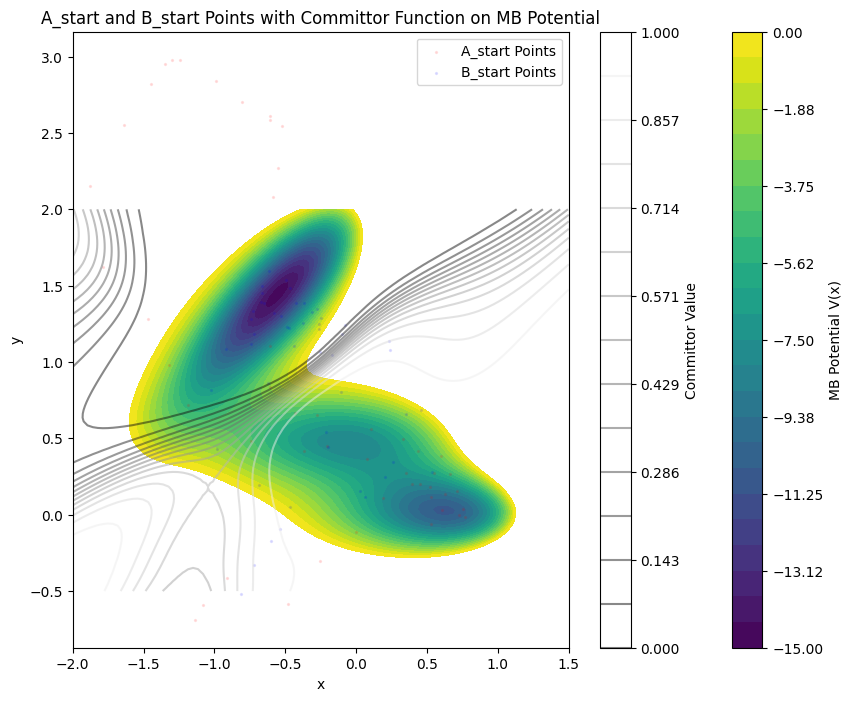

tensor(0.0506, grad_fn=<DivBackward0>)
chain A done
chain B done
chain A done
chain A done
chain B done
chain A done
torch.Size([200, 2])


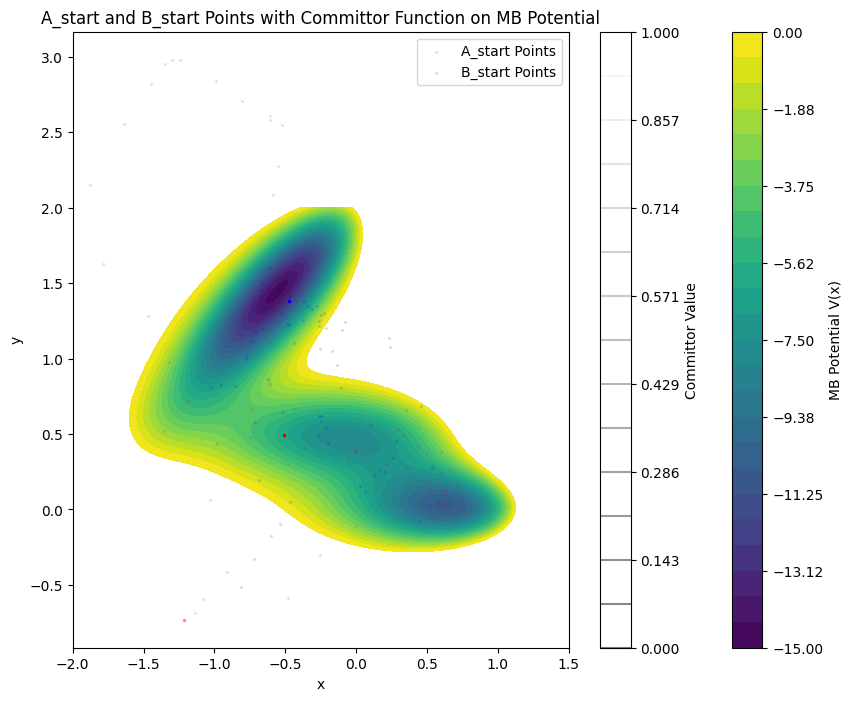

tensor(nan, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [108]:
import torch
import torch.nn as nn

# Neural network embedding of committor
class CommittorNN(nn.Module):
    def __init__(self, input_size=2):  # two-dimensional input for coordinates
        super(CommittorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)  # Input size is 2 (for 2D coordinates)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(-1)

model = CommittorNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def objective(committors_at_start, committors_at_end):
    first = torch.mean((torch.log(committors_at_start) - torch.log(torch.mean(committors_at_end, dim=1))) ** 2)
    second = torch.mean((torch.log(1 - committors_at_start) - torch.log(torch.mean(1 - committors_at_end, dim=1))) ** 2)
    return (first + second) / 2

def learn(model, start_swarm, end_swarm, optimizer):
    k = 1000
    in_A = in_basin_A(end_swarm)  
    in_B = in_basin_B(end_swarm)  
    committors_at_end = torch.where(in_A, torch.tensor(0.0),  torch.where(in_B, torch.tensor(1.0),  model(end_swarm))).view(end_swarm.size(0) // k, k).detach()
    #print(torch.mean(committors_at_end, dim=1))
    # Training loop
    for _ in range(100):  # Example number of epochs
        optimizer.zero_grad()
        # Forward pass: Get committor output for start_swarm
        committors_at_start = model(start_swarm)
        # Compute the custom objective (loss)
        loss = objective(committors_at_start, committors_at_end)

        # Backpropagation and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    return loss


## separate into functions lanch chain
## if chain A done -> reset max_coor and cur_end_coords to a new start point
## append all start coords with max_coor
def chain_A_step(model, max_coor, cur_A_end_coords):
    new_A_coords = simulate_swarm(max_coor)
    if in_basin_B(new_A_coords).all():
        print("all in basin B")
    chain_A_done = in_basin_B(new_A_coords).any()
    cur_A_end_coords = torch.cat((cur_A_end_coords, new_A_coords), dim=0)
    A_commitors = torch.where(in_basin_A(cur_A_end_coords), torch.tensor(0.0), model(cur_A_end_coords))
    if torch.max(A_commitors) > model(max_coor.unsqueeze(0)).item():
        max_idx = torch.argmax(A_commitors, dim=0) 
        max_coor = cur_A_end_coords[max_idx]
    ##A_start_coords = torch.cat((A_start_coords, max_coor.unsqueeze(0)), dim=0)  
    return chain_A_done, max_coor, new_A_coords, cur_A_end_coords

def chain_B_step(model, min_coor, cur_B_end_coords):
    new_B_coords = simulate_swarm(min_coor)
    if in_basin_A(new_B_coords).all():
        print("all in basin B")
    chain_B_done = in_basin_A(new_B_coords).any()
    cur_B_end_coords = torch.cat((cur_B_end_coords, new_B_coords), dim=0)
    B_commitors = torch.where(in_basin_A(cur_B_end_coords), torch.tensor(0.0), model(cur_B_end_coords))
    if torch.min(B_commitors) < model(min_coor.unsqueeze(0)).item():
        min_idx = torch.argmin(B_commitors, dim=0) 
        min_coor = cur_B_end_coords[min_idx]
    ##B_start_coords = torch.cat((B_start_coords, mi _coor.unsqueeze(0)), dim=0)  
    return chain_B_done, min_coor, new_B_coords, cur_B_end_coords

def launch_chains(model, N):
    i = 1
    A_start, B_start = simulation_start(N)
    print("done with starting points")
    A_start, max_coor = A_start[:-1], A_start[-1]
    B_start, min_coor = B_start[:-1], B_start[-1]
    chain_A_done = False
    chain_B_done = False
    all_start_coords = torch.empty((0, 2))
    all_end_coords = torch.empty((0, 2))
    cur_A_end_coords, cur_B_end_coords = max_coor.unsqueeze(0), min_coor.unsqueeze(0)
    while A_start.numel() and B_start.numel():
        if chain_A_done:
            print("chain A done")
            A_start, max_coor= A_start[:-1], A_start[-1]
            cur_A_end_coords = max_coor.unsqueeze(0)
        all_start_coords = torch.cat((all_start_coords, max_coor.unsqueeze(0)), dim=0) 
        chain_A_done, max_coor, new_A_coords, cur_A_end_coords = chain_A_step(model, max_coor, cur_A_end_coords)
        all_end_coords = torch.cat((all_end_coords, new_A_coords), dim=0) 

        if chain_B_done:
            print("chain B done")
            B_start, min_coor = B_start[:-1], B_start[-1]
            cur_B_end_coords = min_coor.unsqueeze(0)
        all_start_coords = torch.cat((all_start_coords, min_coor.unsqueeze(0)), dim=0) 
        chain_B_done, min_coor, new_B_coords, cur_B_end_coords = chain_B_step(model, min_coor, cur_B_end_coords)
        all_end_coords = torch.cat((all_end_coords, new_B_coords), dim=0) 

        loss = learn(model, all_start_coords, all_end_coords, optimizer)
        if not i % 50:
            print(all_start_coords.size())
            plot_end_points_with_committor(all_start_coords[1::2], all_start_coords[0::2], V, model)
            print(loss)
        i += 1
    return

launch_chains(model, 100)

In [109]:
print(i)

NameError: name 'i' is not defined